# Table of Contents

1. Init
2. Defaults for LLM Proxy Models
3. Define Pydantic Model for Structured Output
4. LLM Interaction Function (`generate_text`)
5. Speech Analysis Function for Parallel Processing
6. Data
   - Read Original DataFrame
   - Fix Party Orientation for KKE
   - Read Actual Speeches
7. Exploratory Data Analysis
   - Paragraphs per Speech
   - Words per Speech
   - Words per Speech (Max 2000 Tokens)
   - Speeches per Political Party
8. Processing Sample Speeches to Political Ideologies Scaling Using an LLM
9. Perform Parallel LLM Calls for Analysis and Update DataFrame
10. Visualization
    - Violin Plot of Speech Scaling Scores per Party

## Init

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import dotenv
import openai
import litellm
from litellm import completion
import subprocess
import json
import openai
import litellm
from litellm import completion
from tqdm.notebook import tqdm # Import tqdm for notebooks

import os
import openai
import pandas as pd
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser
from joblib import Parallel, delayed
import time
import json # To parse the JSON string output from the LLM

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from logging import getLogger
logger = getLogger(__name__)
import logging
logging.basicConfig(
    format='%(asctime)s %(levelname)s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)


political_party_EL_map = {
    "SY.RIZ.A.": "ΣΥΡΙΖΑ",
    "N.D.": "ΝΔ",
    "T.P.": "ΠΟΤΑΜΙ",
    "K.K.E.": "ΚΚΕ",
    "Ch.A.": "ΧΑ",
    "AN.EL.": "ΑΝΕΛ",
    "PA.SO.K.": "ΠΑΣΟΚ",
    "DĪ.SY.": "ΔΗΜΑΡ",
    "-": "No Party Affiliation",
    "E.K.": "ΕΝΩΣΗ ΚΕΝΤΡΩΩΝ",
    "LA.E.": "ΛΑΕ",
    "PA.SO.K.;DĪ.SY.": "ΠΑΣΟΚ/ΔΗΜΑΡ"
}
# Define a dictionary to map political parties to colors
political_party_color_palette = {
    "K.K.E.": "#B22222",     # Dark red (leftist)
    "LA.E.": "#CD5C5C",      # Indian red (leftist)
    "SY.RIZ.A.": "#FF69B4",     # Hot pink 
    "DĪ.SY.": "#FFC0CB",  # Pink 
    "PA.SO.K.;DĪ.SY.": "#C8F5C8",  
    "PA.SO.K.": "#32CD32",   # Lime green (center-left)
    "T.P.": "#FFD700",       # Gold (centrist)
    "E.K.": "#FFFF00",       # Yellow (centrist)
    "N.D.": "#0000FF",       # Bright blue (rightist)
    "AN.EL.": "#4682B4",     # Steel blue (rightist)
    "Ch.A.": "#000033",      # Blue-black (far-right)
    "-": "#808080"           # Gray (no affiliation)
}



# print(political_party_color_palette)

### Defaults for LLM proxy models 


In [3]:

dotenv.load_dotenv(Path.home() / '.env')
client = openai.OpenAI(
    api_key=os.environ["LLM_PROXY_ILSP_EVAL_API_KEY"],
    base_url=os.environ["LLM_PROXY_ILSP_BASE_URL"]
)

models_to_test=[ "krikri-dpo-latest",
           #"krikri-dpo",
           "claude-3.7-sonnet",
           "gpt-4o"
          ]

DEFAULT_MODEL = models_to_test[0]
DEFAULT_SYSTEM_PROMPT = "Είσαι ένας βοηθός τεχνητής νοημοσύνης που ειδικεύεσαι στην ανάλυση πολιτικών λόγων και ιδιαίτερα κοινοβουλευτικών ομιλιών. Χρειάζεται να αναλύσεις την παρακάτω κοινοβουλευτική ομιλία και να την κατατάξεις όσον αφορά την πολιτική τάση που εκφράζει. Πρέπει να εκφράσεις την κατάταξή σου αποδίδοντας ένα σκορ από το 1 ως το 10, όπου το 1 αναπαριστά την άκρα αριστερά και το 10 την άκρα δεξιά. Πρέπει επίσης να αιτιολογήσεις την κατάταξή σου."

DEFAULT_USER_PROMPT = "Χρειάζεται να αναλύσεις την παρακάτω κοινοβουλευτική ομιλία και να την κατατάξεις όσον αφορά την πολιτική τάση που εκφράζει. Πρέπει να εκφράσεις την κατάταξή σου αποδίδοντας ένα σκορ από το 1 ως το 10, όπου το 1 αναπαριστά την άκρα αριστερά και το 10 την άκρα δεξιά. Πρέπει επίσης να αιτιολογήσεις την κατάταξή σου."


### Define Pydantic Model for Structured Output


In [4]:


class PoliticalSpeechAnalysis(BaseModel):
    justification: str = Field(description="Λεπτομερής αιτιολόγηση της πολιτικής κατεύθυνσης της ομιλίας.")
    score: int = Field(description="Βαθμολογία από 1 έως 10, όπου το 1 είναι άκρα αριστερά και το 10 είναι άκρα δεξιά.")

parser = PydanticOutputParser(pydantic_object=PoliticalSpeechAnalysis)

template = """
Είσαι ένας βοηθός τεχνητής νοημοσύνης που ειδικεύεσαι στην ανάλυση πολιτικών λόγων και ιδιαίτερα κοινοβουλευτικών ομιλιών. Χρειάζεται να αναλύσεις την παρακάτω κοινοβουλευτική ομιλία και να την κατατάξεις όσον αφορά την πολιτική τάση που εκφράζει. Πρέπει να εκφράσεις την κατάταξή σου αποδίδοντας ένα σκορ από το 1 ως το 10, όπου το 1 αναπαριστά την άκρα αριστερά και το 10 την άκρα δεξιά. Πρέπει επίσης να αιτιολογήσεις την κατάταξή σου.

---
Ομιλία:
{speech_text}
---

{format_instructions}
"""



example_speech_text = """
This government is committed to ensuring true freedom for every citizen. We believe in minimal taxation,
empowering individuals to make their own choices, and a strong national defense that protects our
sovereignty without entanglement in foreign conflicts. Personal responsibility is paramount.
"""

# Format the template with the example speech and the parser's instructions
# This will produce the exact string that would be sent to the LLM as the user_prompt.
formatted_query = template.format(
    speech_text=example_speech_text,
    format_instructions=parser.get_format_instructions()
)

print("--- Formatted LLM Query Preview ---")
print(formatted_query)
print("---------------------------------")

--- Formatted LLM Query Preview ---

Είσαι ένας βοηθός τεχνητής νοημοσύνης που ειδικεύεσαι στην ανάλυση πολιτικών λόγων και ιδιαίτερα κοινοβουλευτικών ομιλιών. Χρειάζεται να αναλύσεις την παρακάτω κοινοβουλευτική ομιλία και να την κατατάξεις όσον αφορά την πολιτική τάση που εκφράζει. Πρέπει να εκφράσεις την κατάταξή σου αποδίδοντας ένα σκορ από το 1 ως το 10, όπου το 1 αναπαριστά την άκρα αριστερά και το 10 την άκρα δεξιά. Πρέπει επίσης να αιτιολογήσεις την κατάταξή σου.

---
Ομιλία:

This government is committed to ensuring true freedom for every citizen. We believe in minimal taxation,
empowering individuals to make their own choices, and a strong national defense that protects our
sovereignty without entanglement in foreign conflicts. Personal responsibility is paramount.

---

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "ar

### LLM Interaction Function (`generate_text`)


In [5]:

def generate_text(
    client,
    model=DEFAULT_MODEL,
    system_prompt=DEFAULT_SYSTEM_PROMPT,
    user_prompt=DEFAULT_USER_PROMPT,
    temperature=0.5, # Setting to 0.0 for consistent analysis results
    max_tokens=5000,
    top_p=0.9,
    frequency_penalty=0.0,
    presence_penalty=0.0,
):
    """
    Generates text using the litellm library (or any OpenAI-compatible client).

    Args:
        client (openai.OpenAI): The initialized OpenAI client connected to LiteLLM proxy.
        model (str): The language model to use.
        system_prompt (str): The system prompt for the model.
        user_prompt (str): The user's input prompt.
        temperature (float): Controls the randomness of the output.
        max_tokens (int): Limits the length of the generated response.
        top_p (float): Controls nucleus sampling.
        frequency_penalty (float): Penalizes repeated tokens.
        presence_penalty (float): Penalizes new tokens.

    Returns:
        str: The generated text, or None if there was an error.
    """
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
            ],
            temperature=temperature,
            max_tokens=max_tokens,
            top_p=top_p,
            frequency_penalty=frequency_penalty,
            presence_penalty=presence_penalty,
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error generating text: {e}")
        return None

print("`generate_text` function defined.")

`generate_text` function defined.


### Speech Analysis Function for Parallel Processing


In [6]:

def analyze_speech(speech_text: str, model_name: str = DEFAULT_MODEL):
    """
    Analyzes a single political speech text using generate_text and returns its
    score and justification. This function is designed to be called in parallel.
    """
    try:
        # Initialize client inside the function for joblib parallelization.
        # This ensures each worker process has its own, independent connection.
        client = openai.OpenAI(
            api_key=os.environ["LLM_PROXY_ILSP_EVAL_API_KEY"],
            base_url=os.environ["LLM_PROXY_ILSP_BASE_URL"]
        )

        # Format the user prompt using the global template string
        formatted_user_prompt = template.format(
            speech_text=speech_text,
            format_instructions=parser.get_format_instructions()
        )

        # Call the generate_text function to get raw LLM output
        raw_llm_output = generate_text(
            client=client,
            model=model_name,
            system_prompt="You are an AI assistant specialized in analyzing political discourse. Always output in the specified JSON format.",
            user_prompt=formatted_user_prompt,
            temperature=0.0 # Maintain consistency for analysis
        )

        if raw_llm_output:
            # Parse the raw LLM output into our Pydantic model
            analysis = parser.parse(raw_llm_output)
            return {
                "score": analysis.score,
                "justification": analysis.justification
            }
        else:
            return {
                "score": None,
                "justification": "LLM returned no content or failed to generate."
            }
    except json.JSONDecodeError as e:
        # Catch specific JSON parsing errors from LLM output
        return {
            "score": None,
            "justification": f"JSON parsing error: {e}. Raw LLM output (partial): {raw_llm_output[:200]}..."
        }
    except Exception as e:
        # Catch any other unexpected errors during the process
        return {
            "score": None,
            "justification": f"General error during analysis: {e}"
        }

print("`analyze_speech` function defined.")

`analyze_speech` function defined.


## Data

### Read original df


In [7]:

data_dir = Path("./data/2015_data/")
speeches_dir = data_dir / "speeches"
n_jobs = 3

# Define the file path
file_path = data_dir / "grouped_output.xlsx"

# Read the Excel file
try:
    df = pd.read_excel(file_path)
    # Map speaker party initials to full names using party_map
    df['Speaker_party_EL'] = df['Speaker_party'].map(political_party_EL_map)    
    print(df.head())  # Display the first few rows of the dataframe
except FileNotFoundError:
    print(f"File not found: {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")



        Date                     Speaker_ID  \
0 2015-02-05     ΤΡΑΓΑΚΗΣ_ΠΑΝΑΓΙΩΤΗ_ΙΩΑΝΝΗΣ   
1 2015-02-06  ΒΑΡΒΙΤΣΙΩΤΗΣ_ΙΩΑΝΝΗ_ΜΙΛΤΙΑΔΗΣ   
2 2015-02-06  ΒΕΣΥΡΟΠΟΥΛΟΣ_ΦΩΤΙΟΥ_ΑΠΟΣΤΟΛΟΣ   
3 2015-02-06   ΘΕΟΔΩΡΑΚΗΣ_ΠΑΝΑΓΙΩΤΗ_ΣΤΑΥΡΟΣ   
4 2015-02-06         ΚΩΝΣΤΑΝΤΟΠΟΥΛΟΥ_Ν._ΖΩΗ   

                                              speech Speaker_role Speaker_MP  \
0     2015-02-05_name_ΤΡΑΓΑΚΗΣ_ΠΑΝΑΓΙΩΤΗ_ΙΩΑΝΝΗΣ.txt  Chairperson         MP   
1  2015-02-06_name_ΒΑΡΒΙΤΣΙΩΤΗΣ_ΙΩΑΝΝΗ_ΜΙΛΤΙΑΔΗΣ.txt      Regular         MP   
2  2015-02-06_name_ΒΕΣΥΡΟΠΟΥΛΟΣ_ΦΩΤΙΟΥ_ΑΠΟΣΤΟΛΟΣ.txt      Regular         MP   
3   2015-02-06_name_ΘΕΟΔΩΡΑΚΗΣ_ΠΑΝΑΓΙΩΤΗ_ΣΤΑΥΡΟΣ.txt      Regular         MP   
4         2015-02-06_name_ΚΩΝΣΤΑΝΤΟΠΟΥΛΟΥ_Ν._ΖΩΗ.txt  Chairperson         MP   

  Speaker_minister Speaker_party      Party_orientation Speaker_gender  \
0      notMinister          N.D.           Centre-right              M   
1      notMinister          N.D.           Centre-right              M   
2      notMini

### Problems with party_orientation for KKE? Fix them temporarily: assign a Left to far-left Party orientation as for ΛΑΕ


In [8]:
# Define the number of random rows to print
n = 5

# Filter rows where Speaker_party_EL is ΚΚΕ
kke_speeches = df[df['Speaker_party_EL'] == 'ΚΚΕ']

# Sample n random rows
random_kke_speeches = kke_speeches.sample(n=n, random_state=42)

# Print the sampled rows
print(random_kke_speeches)


           Date                        Speaker_ID  \
4233 2015-12-10          ΚΑΤΣΩΤΗΣ_ΠΕΡΙΚΛΗ_ΧΡΗΣΤΟΣ   
123  2015-02-10   ΚΟΥΤΣΟΥΜΠΑΣ_ΑΠΟΣΤΟΛΟΥ_ΔΗΜΗΤΡΙΟΣ   
864  2015-04-27          ΚΑΤΣΩΤΗΣ_ΠΕΡΙΚΛΗ_ΧΡΗΣΤΟΣ   
914  2015-04-28           ΓΚΙΟΚΑΣ_ΧΡΗΣΤΟΥ_ΙΩΑΝΝΗΣ   
390  2015-03-19  ΚΑΡΑΘΑΝΑΣΟΠΟΥΛΟΣ_ΠΕΤΡΟΥ_ΝΙΚΟΛΑΟΣ   

                                                 speech Speaker_role  \
4233       2015-12-10_name_ΚΑΤΣΩΤΗΣ_ΠΕΡΙΚΛΗ_ΧΡΗΣΤΟΣ.txt      Regular   
123   2015-02-10_name_ΚΟΥΤΣΟΥΜΠΑΣ_ΑΠΟΣΤΟΛΟΥ_ΔΗΜΗΤΡΙΟ...      Regular   
864        2015-04-27_name_ΚΑΤΣΩΤΗΣ_ΠΕΡΙΚΛΗ_ΧΡΗΣΤΟΣ.txt      Regular   
914         2015-04-28_name_ΓΚΙΟΚΑΣ_ΧΡΗΣΤΟΥ_ΙΩΑΝΝΗΣ.txt      Regular   
390   2015-03-19_name_ΚΑΡΑΘΑΝΑΣΟΠΟΥΛΟΣ_ΠΕΤΡΟΥ_ΝΙΚΟΛΑ...      Regular   

     Speaker_MP Speaker_minister Speaker_party Party_orientation  \
4233         MP      notMinister        K.K.E.                 -   
123          MP      notMinister        K.K.E.                 -   
864          MP      notMinister        K.K.

In [9]:
# Assign "Left to far-left" political orientation to ΚΚΕ
df.loc[df['Speaker_party_EL'] == 'ΚΚΕ', 'Party_orientation'] = 'Left to far-left'

# Verify the change
print(df[df['Speaker_party_EL'] == 'ΚΚΕ'][['Speaker_party_EL', 'Party_orientation']].drop_duplicates())

   Speaker_party_EL Party_orientation
34              ΚΚΕ  Left to far-left


In [10]:
# Print the parties and their political orientation
print(df[['Speaker_party_EL', 'Party_orientation']].drop_duplicates())


          Speaker_party_EL       Party_orientation
0                       ΝΔ            Centre-right
3                   ΠΟΤΑΜΙ   Centre to centre-left
4                   ΣΥΡΙΖΑ     Centre-left to left
11    No Party Affiliation                       -
13                   ΠΑΣΟΚ             Centre-left
16                      ΧΑ               Far-right
21                    ΑΝΕΛ                   Right
34                     ΚΚΕ        Left to far-left
2552                   ΛΑΕ        Left to far-left
2593        ΕΝΩΣΗ ΚΕΝΤΡΩΩΝ                  Centre
2606                 ΔΗΜΑΡ             Centre-left
2688           ΠΑΣΟΚ/ΔΗΜΑΡ  Centre-leftCentre-left


### Read actual speeches in the df

In [11]:
from joblib import Parallel, delayed

# Function to create the path for each speech
def create_path(row):
    return speeches_dir / row['speech']

# Generate paths for speeches
df["paths"] = df.apply(create_path, axis=1)

# Function to read and split the speech file
def read_and_split(path):
    try:
        with open(path, 'r', encoding='utf-8') as inf:
            text = inf.read()
            paragraphs = [
                {"text": p.strip(), "length": len(p.strip().split())}
                for p in text.split("\n") if p.strip()
            ]
            return text, paragraphs
    except Exception as e:
        print(f"Error reading file {path}: {e}")
        return "", []

# Use joblib to parallelize the reading and splitting of speeches
results = Parallel(n_jobs=n_jobs)(delayed(read_and_split)(path) for path in df["paths"])

# Unpack the results into separate columns
df["text"], df["paragraphs"] = zip(*results)

# Display the updated DataFrame
print(df[["paths", "text", "paragraphs"]].head())  # Display paths, full text, and paragraphs

                                               paths  \
0  data/2015_data/speeches/2015-02-05_name_ΤΡΑΓΑΚ...   
1  data/2015_data/speeches/2015-02-06_name_ΒΑΡΒΙΤ...   
2  data/2015_data/speeches/2015-02-06_name_ΒΕΣΥΡΟ...   
3  data/2015_data/speeches/2015-02-06_name_ΘΕΟΔΩΡ...   
4  data/2015_data/speeches/2015-02-06_name_ΚΩΝΣΤΑ...   

                                                text  \
0  Κυρίες και κύριοι Βουλευτές, συγκαλείται η Βου...   
1  Εγώ, κυρία Πρόεδρε.\nΚυρία Πρόεδρε, εφόσον υπά...   
2              Δεν μπορούν να γίνουν δύο ψηφοφορίες;   
3  Κυρία Πρόεδρε, μπορώ να έχω τον λόγο;\nΔεν ξέρ...   
4  Κυρίες και κύριοι Βουλευτές, κυρίες και κύριοι...   

                                          paragraphs  
0  [{'text': 'Κυρίες και κύριοι Βουλευτές, συγκαλ...  
1  [{'text': 'Εγώ, κυρία Πρόεδρε.', 'length': 3},...  
2  [{'text': 'Δεν μπορούν να γίνουν δύο ψηφοφορίε...  
3  [{'text': 'Κυρία Πρόεδρε, μπορώ να έχω τον λόγ...  
4  [{'text': 'Κυρίες και κύριοι Βουλευτές, κυρίες..

### EDA


#### Paragraphs per speech


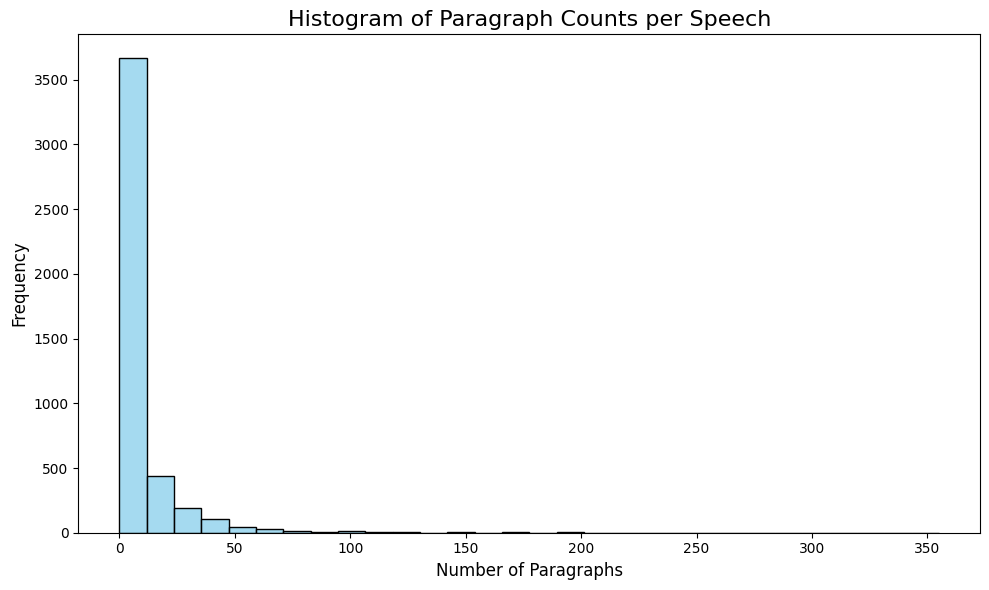

In [12]:
def count_paragraphs(paragraphs):
    return len(paragraphs)

paragraph_counts = Parallel(n_jobs=n_jobs)(delayed(count_paragraphs)(paragraphs) for paragraphs in df['paragraphs'])

# Create a histogram using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(paragraph_counts, bins=30, kde=False, color='skyblue')
plt.title('Histogram of Paragraph Counts per Speech', fontsize=16)
plt.xlabel('Number of Paragraphs', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()


#### Words per speech


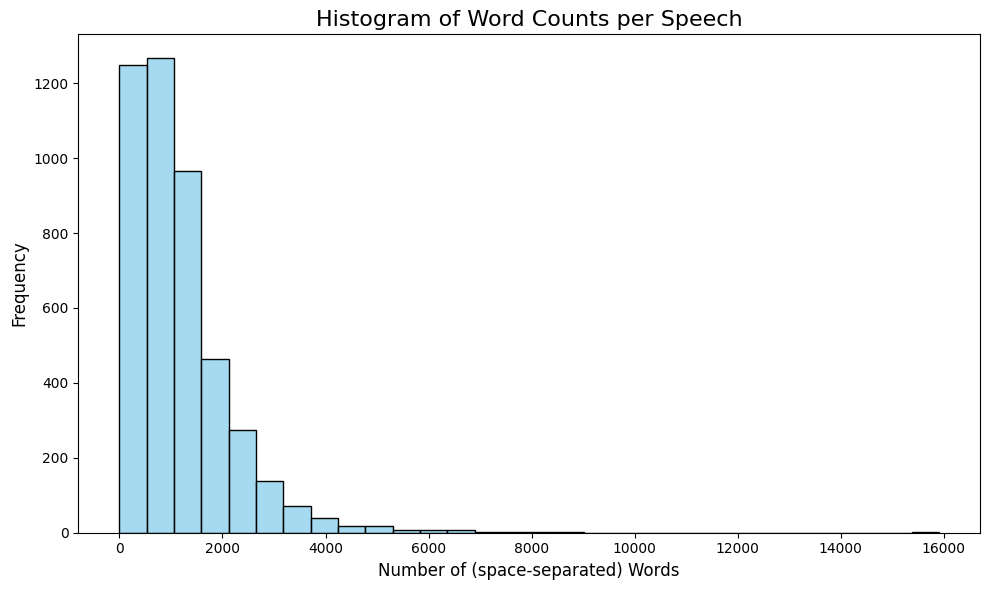

In [13]:
# Define max_length variable
max_length = np.inf  # Set initial value to infinity
#max_length = 2000

# Function to calculate the length of a speech
def calculate_length(text):
    return len(text.split())

# Use joblib to parallelize the calculation of speech lengths
speech_lengths = Parallel(n_jobs=n_jobs)(delayed(calculate_length)(text) for text in df["text"])

# Filter lengths based on max_length
filtered_lengths = [length for length in speech_lengths if length <= max_length]

# Create a histogram using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(filtered_lengths, bins=30, kde=False, color='skyblue')
plt.title('Histogram of Word Counts per Speech', fontsize=16)
plt.xlabel('Number of (space-separated) Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

#### Words per speech (max 2000 tokens)


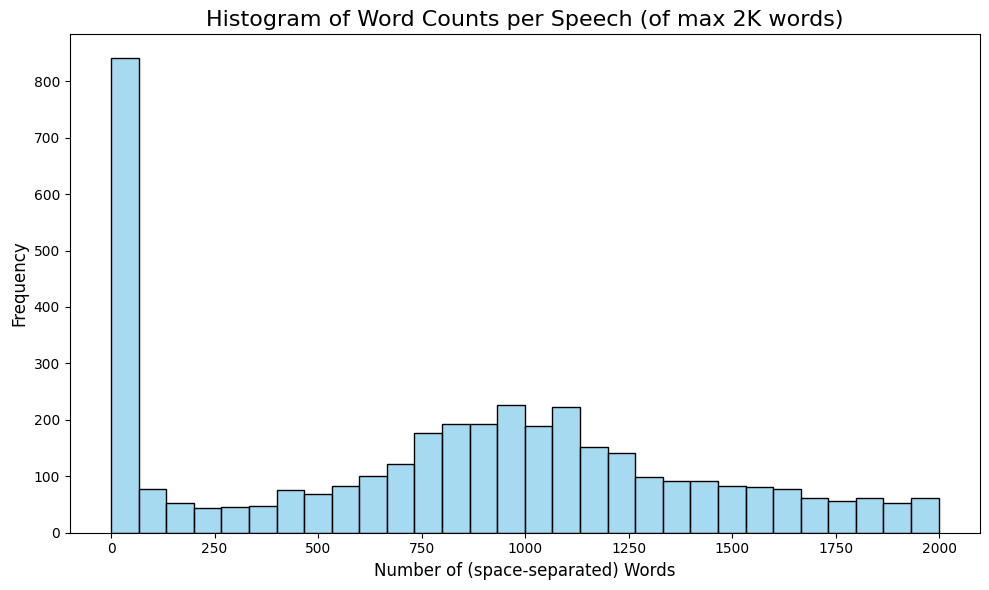

In [14]:
# Define max_length variable
max_length = 2000

# Function to calculate the length of a speech
def calculate_length(text):
    return len(text.split())

# Use joblib to parallelize the calculation of speech lengths
speech_lengths = Parallel(n_jobs=n_jobs)(delayed(calculate_length)(text) for text in df["text"])

# Filter lengths based on max_length
filtered_lengths = [length for length in speech_lengths if length <= max_length]

# Create a histogram using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(filtered_lengths, bins=30, kde=False, color='skyblue')
plt.title('Histogram of Word Counts per Speech (of max 2K words)', fontsize=16)
plt.xlabel('Number of (space-separated) Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()


#### Speeches per political party


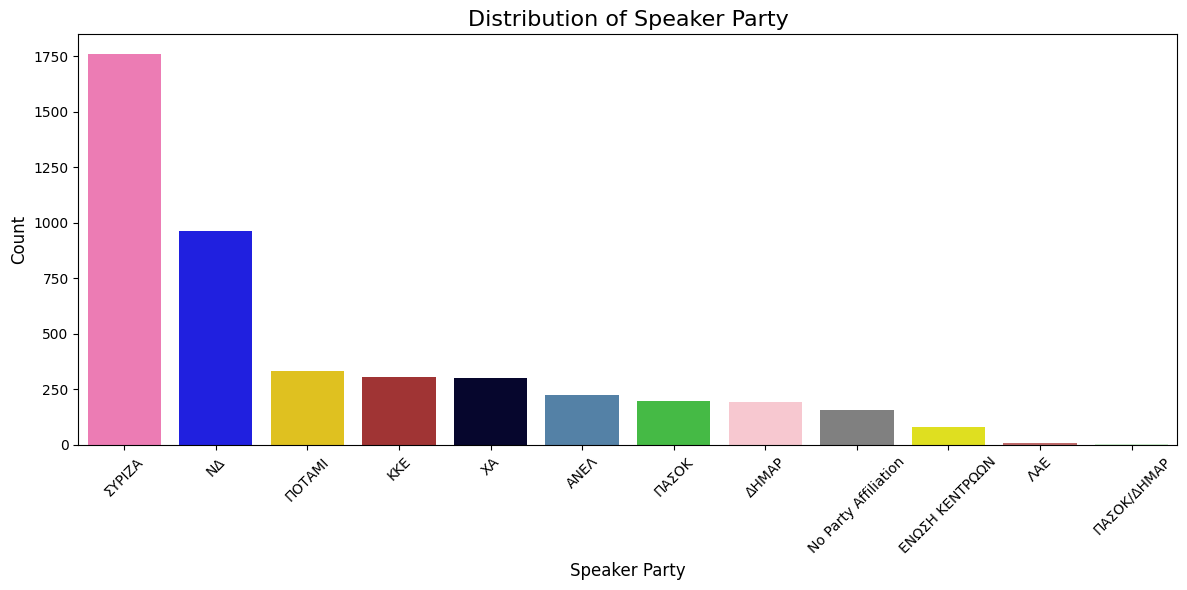

In [15]:
# Create a bar plot using seaborn with the updated party names and colors
plt.figure(figsize=(12, 6))
sns.barplot(
    x=df['Speaker_party_EL'].value_counts().index, 
    y=df['Speaker_party_EL'].value_counts().values, 
    hue=df['Speaker_party_EL'].value_counts().index,  # Assign hue to x variable
    palette=[political_party_color_palette[party] for party in df['Speaker_party'].value_counts().index],
    legend=False  # Disable legend for the same effect
)
plt.title('Distribution of Speaker Party', fontsize=16)
plt.xlabel('Speaker Party', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Processing of sample speeches to political ideologies scaling using an LLM

In [16]:
# Filter parties with at least 10 speeches
eligible_parties = df['Speaker_party_EL'].value_counts()
eligible_parties = eligible_parties[eligible_parties >= 100].index

sample_n = 100
# Sample sample_n speeches for each eligible party
sample_df = df[df['Speaker_party_EL'].isin(eligible_parties)].groupby('Speaker_party_EL')[ df.columns].apply(lambda x: x.sample(n=sample_n, random_state=42))

# Reset index for the sampled DataFrame
sample_df = sample_df.reset_index(drop=True)

# Display the sampled DataFrame parties
print(set(sample_df["Speaker_party"].unique()))

# print(sample_df.sample(n=2))

print(sample_df.info())




{'Ch.A.', 'N.D.', 'K.K.E.', 'PA.SO.K.', '-', 'T.P.', 'AN.EL.', 'DĪ.SY.', 'SY.RIZ.A.'}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               900 non-null    datetime64[ns]
 1   Speaker_ID         900 non-null    object        
 2   speech             900 non-null    object        
 3   Speaker_role       900 non-null    object        
 4   Speaker_MP         900 non-null    object        
 5   Speaker_minister   900 non-null    object        
 6   Speaker_party      900 non-null    object        
 7   Party_orientation  900 non-null    object        
 8   Speaker_gender     900 non-null    object        
 9   Speaker_party_EL   900 non-null    object        
 10  paths              900 non-null    object        
 11  text               900 non-null    object        
 12  paragraphs         900 non-null   

#### Perform Parallel LLM calls for Analysis and Update DataFrame

In [18]:

# Determine the number of parallel jobs. -1 means use all available CPU cores.
# Adjust this based on your LiteLLM proxy capacity and LLM provider rate limits.
n_jobs = 3
model_to_use = DEFAULT_MODEL # Use the default model defined earlier

print(f"\nStarting parallel analysis with {n_jobs} jobs using model: {model_to_use}...")
start_time = time.time()

# Use joblib to run the `analyze_speech` function for each speech text in parallel
# `delayed` wraps the function call, and `Parallel` distributes them
# loky is a robust and reusable process pool executor for joblib. It's essentially a more advanced and reliable alternative to Python's built-in multiprocessing.Pool.

results = Parallel(n_jobs=n_jobs, backend="loky")(
    delayed(analyze_speech)(text, model_to_use)
    for text in tqdm(sample_df["text"], total=len(sample_df["text"]), desc="Analyzing Speeches")
)
end_time = time.time()
print(f"Analysis completed in {end_time - start_time:.2f} seconds.")

# Store the results back into the DataFrame
sample_df["Speech_scaling_score"] = [res["score"] for res in results]
sample_df["Speech_justification"] = [res["justification"] for res in results]

print("\nDataFrame after analysis:")
print(sample_df)


Starting parallel analysis with 3 jobs using model: krikri-dpo-latest...


Analyzing Speeches:   0%|          | 0/900 [00:00<?, ?it/s]

Analysis completed in 1743.06 seconds.

DataFrame after analysis:
          Date                       Speaker_ID  \
0   2015-10-07        ΔΗΜΗΤΡΙΟΣ_ΠΑΠΑΓΓΕΛΟΠΟΥΛΟΣ   
1   2015-06-27                 ΙΩΑΝΝΗΣ_ΤΣΙΡΩΝΗΣ   
2   2015-07-22         ΝΙΚΟΛΑΟΣ_ΠΑΡΑΣΚΕΥΟΠΟΥΛΟΣ   
3   2015-07-09                 ΔΗΜΗΤΡΙΟΣ_ΜΑΡΔΑΣ   
4   2015-11-06                 ΤΡΥΦΩΝ_ΑΛΕΞΙΑΔΗΣ   
..         ...                              ...   
895 2015-07-15  ΠΑΝΑΓΙΩΤΑΡΟΣ_ΚΩΝΣΤΑΝΤΙΝΟΥ_ΗΛΙΑΣ   
896 2015-07-10          ΜΙΧΟΣ_ΑΝΤΩΝΙΟΥ_ΝΙΚΟΛΑΟΣ   
897 2015-05-28              ΠΑΠΠΑΣ_ΗΛΙΑ_ΧΡΗΣΤΟΣ   
898 2015-05-06        ΓΡΕΓΟΣ_ΒΑΣΙΛΕΙΟΥ_ΑΝΤΩΝΙΟΣ   
899 2015-11-05       ΚΑΣΙΔΙΑΡΗΣ_ΠΑΝΑΓΙΩΤΗ_ΗΛΙΑΣ   

                                                speech Speaker_role  \
0        2015-10-07_name_ΔΗΜΗΤΡΙΟΣ_ΠΑΠΑΓΓΕΛΟΠΟΥΛΟΣ.txt      Regular   
1                 2015-06-27_name_ΙΩΑΝΝΗΣ_ΤΣΙΡΩΝΗΣ.txt      Regular   
2         2015-07-22_name_ΝΙΚΟΛΑΟΣ_ΠΑΡΑΣΚΕΥΟΠΟΥΛΟΣ.txt      Regular   
3                 2015-07-09_name_ΔΗΜ

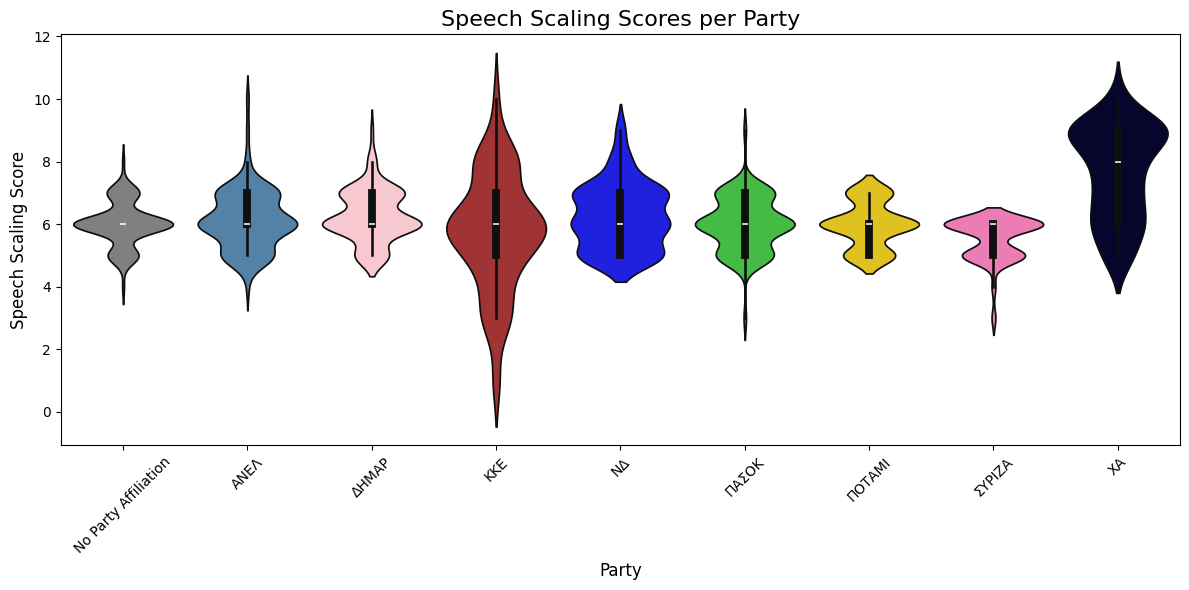

In [21]:
import seaborn as sns

# Create a violin plot using Speech scaling scores and Speaker_party_EL
plt.figure(figsize=(12, 6))
sns.violinplot(
    data=sample_df,
    x="Speaker_party_EL",
    y="Speech_scaling_score",
    hue="Speaker_party_EL",  # Assign the x variable to hue
    palette=[political_party_color_palette[party] for party in sample_df['Speaker_party'].unique()],
    legend=False,  # Disable legend for the same effect
    density_norm='width'
)

# Customize the plot
plt.title("Speech Scaling Scores per Party", fontsize=16)
plt.xlabel("Party", fontsize=12)
plt.ylabel("Speech Scaling Score", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [20]:
# Print a sample of justifications
sample_justifications = sample_df["Speech_justification"].sample(n=5, random_state=42)
print(sample_justifications)

70     Η ομιλία παρουσιάζει μια συντηρητική προσέγγισ...
827    Η ομιλία χαρακτηρίζεται από εθνικιστικά στοιχε...
231    Η ομιλία εκφράζει μια κεντροαριστερή/σοσιαλδημ...
588    The speech exhibits a centrist to mildly progr...
39     Η συγκεκριμένη κοινοβουλευτική ομιλία παρουσιά...
Name: Speech_justification, dtype: object


In [ ]:
import pandas as pd
import numpy as np

# # Δημιουργία δείγματος δεδομένων
# data = {
#     'Date': pd.to_datetime(['2024-03-10', '2024-03-10', '2024-03-11', '2024-03-11', '2024-03-12', '2024-03-12']),
#     'Speaker_ID': ['SPK001', 'SPK002', 'SPK003', 'SPK004', 'SPK001', 'SPK005'],
#     'speech': [
#         "Κυρίες και κύριοι συνάδελφοι, η οικονομία μας βρίσκεται σε κρίσιμο σημείο. Πρέπει να προωθήσουμε μεταρρυθμίσεις που θα ενισχύσουν την ανταγωνιστικότητα και θα μειώσουν τη γραφειοκρατία, ώστε να προσελκύσουμε επενδύσεις. Η ανάπτυξη θα έρθει μέσα από την ελευθερία της αγοράς και την ελαχιστοποίηση της κρατικής παρέμβασης. Οι πολίτες πρέπει να έχουν την ευθύνη των επιλογών τους.",
#         "Ο προϋπολογισμός που παρουσιάστηκε σήμερα δεν ανταποκρίνεται στις ανάγκες της κοινωνίας. Είναι απαράδεκτο να περικόπτονται οι δαπάνες για την υγεία και την παιδεία, ενώ ταυτόχρονα να ευνοούνται οι λίγοι. Ζητάμε αναδιανομή του πλούτου, ενίσχυση του κοινωνικού κράτους και προστασία των αδύναμων. Η αλληλεγγύη είναι η απάντηση στα προβλήματα της εποχής μας.",
#         "Η ενεργειακή μετάβαση αποτελεί εθνική προτεραιότητα. Πρέπει να επενδύσουμε σε ανανεώσιμες πηγές ενέργειας και να προωθήσουμε την πράσινη ανάπτυξη. Η προστασία του περιβάλλοντος δεν είναι πολυτέλεια, αλλά αναγκαιότητα για τις επόμενες γενιές. Χρειάζεται συνεργασία όλων των κομμάτων για αυτόν τον στόχο.",
#         "Δεν μπορούμε να αγνοούμε τις ανησυχίες των αγροτών μας. Η αγροτική παραγωγή είναι η ραχοκοκαλιά της οικονομίας μας και πρέπει να στηρίξουμε τον πρωτογενή τομέα με κάθε δυνατό τρόπο. Οι επιδοτήσεις πρέπει να είναι στοχευμένες και να διασφαλίζουν την επιβίωση του Έλληνα αγρότη, ενισχύοντας την εθνική αυτάρκεια.",
#         "Ο ψηφιακός μετασχηματισμός του κράτους είναι αδιαπραγμάτευτος. Πρέπει να εκσυγχρονίσουμε τις δημόσιες υπηρεσίες, να απλοποιήσουμε τις διαδικασίες και να προσφέρουμε στους πολίτες άμεση πρόσβαση στις πληροφορίες. Η διαφάνεια και η αποτελεσματικότητα είναι οι αρχές μας σε αυτόν τον τομέα.",
#         "Η πολιτιστική μας κληρονομιά είναι το DNA του έθνους μας. Πρέπει να την προστατεύσουμε, να την αναδείξουμε και να την μεταλαμπαδεύσουμε στις νέες γενιές. Ο πολιτισμός είναι η ασπίδα μας απέναντι στην παγκοσμιοποίηση και η πηγή της εθνικής μας υπερηφάνειας."
#     ],
#     'Speaker_role': ['Βουλευτής', 'Βουλευτής', 'Υπουργός', 'Βουλευτής', 'Υπουργός', 'Βουλευτής'],
#     'Speaker_MP': [True, True, True, True, True, True],
#     'Speaker_minister': [False, False, True, False, True, False],
#     'Speaker_party': ['N.D.', 'SY.RIZ.A.', 'N.D.', 'Ch.A.', 'N.D.', 'PA.SO.K.'],

#     'Party_orientation': ['Δεξιά', 'Αριστερά', 'Δεξιά', 'Ακρα Δεξιά', 'Δεξιά', 'Κέντρο-Αριστερά'],
#     'Speaker_gender': ['Άνδρας', 'Γυναίκα', 'Άνδρας', 'Άνδρας', 'Γυναίκα', 'Άνδρας'],
#     'Speaker_party_EL': ['ΝΔ', 'ΣΥΡΙΖΑ', 'ΝΔ', 'ΕΛ', 'ΝΔ', 'ΠΑΣΟΚ'],
#     'paths': [f'/data/speeches/speech_{i:03d}.txt' for i in range(1, 7)],
#     'text': [ # Αυτή η στήλη συνήθως περιέχει το ίδιο κείμενο με το 'speech' αν δεν γίνεται κάποια επεξεργασία
#         "Κυρίες και κύριοι συνάδελφοι, η οικονομία μας βρίσκεται σε κρίσιμο σημείο. Πρέπει να προωθήσουμε μεταρρυθμίσεις που θα ενισχύσουν την ανταγωνιστικότητα και θα μειώσουν τη γραφειοκρατία, ώστε να προσελκύσουμε επενδύσεις. Η ανάπτυξη θα έρθει μέσα από την ελευθερία της αγοράς και την ελαχιστοποίηση της κρατικής παρέμβασης. Οι πολίτες πρέπει να έχουν την ευθύνη των επιλογών τους.",
#         "Ο προϋπολογισμός που παρουσιάστηκε σήμερα δεν ανταποκρίνεται στις ανάγκες της κοινωνίας. Είναι απαράδεκτο να περικόπτονται οι δαπάνες για την υγεία και την παιδεία, ενώ ταυτόχρονα να ευνοούνται οι λίγοι. Ζητάμε αναδιανομή του πλούτου, ενίσχυση του κοινωνικού κράτους και προστασία των αδύναμων. Η αλληλεγγύη είναι η απάντηση στα προβλήματα της εποχής μας.",
#         "Η ενεργειακή μετάβαση αποτελεί εθνική προτεραιότητα. Πρέπει να επενδύσουμε σε ανανεώσιμες πηγές ενέργειας και να προωθήσουμε την πράσινη ανάπτυξη. Η προστασία του περιβάλλοντος δεν είναι πολυτέλεια, αλλά αναγκαιότητα για τις επόμενες γενιές. Χρειάζεται συνεργασία όλων των κομμάτων για αυτόν τον στόχο.",
#         "Δεν μπορούμε να αγνοούμε τις ανησίες των αγροτών μας. Η αγροτική παραγωγή είναι η ραχοκοκαλιά της οικονομίας μας και πρέπει να στηρίξουμε τον πρωτογενή τομέα με κάθε δυνατό τρόπο. Οι επιδοτήσεις πρέπει να είναι στοχευμένες και να διασφαλίζουν την επιβίωση του Έλληνα αγρότη, ενισχύοντας την εθνική αυτάρκεια.",
#         "Ο ψηφιακός μετασχηματισμός του κράτους είναι αδιαπραγμάτευτος. Πρέπει να εκσυγχρονίσουμε τις δημόσιες υπηρεσίες, να απλοποιήσουμε τις διαδικασίες και να προσφέρουμε στους πολίτες άμεση πρόσβαση στις πληροφορίες. Η διαφάνεια και η αποτελεσματικότητα είναι οι αρχές μας σε αυτόν τον τομέα.",
#         "Η πολιτιστική μας κληρονομιά είναι το DNA του έθνους μας. Πρέπει να την προστατεύσουμε, να την αναδείξουμε και να την μεταλαμπαδεύσουμε στις νέες γενιές. Ο πολιτισμός είναι η ασπίδα μας απέναντι στην παγκοσμιοποίηση και η πηγή της εθνικής μας υπερηφάνειας."
#     ]
# }

# sample_df = pd.DataFrame(data)

# print(sample_df.head())
# print(sample_df.columns)